In [11]:
# Setting up env variables for cleaner command line commands.
import os

%env KEY=tlt_encode
%env NUM_GPUS=1
%env USER_EXPERIMENT_DIR=/workspace/tlt-experiments/detectnet_v2
%env DATA_DOWNLOAD_DIR=/workspace/tlt-experiments/data

# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=~/tlt-samples/detectnet_v2

# Please define this local project directory that needs to be mapped to the TLT docker session.
# The dataset expected to be present in $LOCAL_PROJECT_DIR/data, while the results for the steps
# in this notebook will be stored at $LOCAL_PROJECT_DIR/detectnet_v2
# !PLEASE MAKE SURE TO UPDATE THIS PATH!.

os.environ["LOCAL_PROJECT_DIR"] = "/home/ucit/TESTData"

os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "data"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "detectnet_v2"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)
%env SPECS_DIR=/workspace/tlt-experiments/detectnet_v2/specs

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR

env: KEY=tlt_encode
env: NUM_GPUS=1
env: USER_EXPERIMENT_DIR=/workspace/tlt-experiments/detectnet_v2
env: DATA_DOWNLOAD_DIR=/workspace/tlt-experiments/data
env: SPECS_DIR=/workspace/tlt-experiments/detectnet_v2/specs
total 92
-rw-rw-r-- 1 ucit ucit 5598 2月  25 21:15 detectnet_v2_train_resnet18_kitti.txt
-rw-rw-r-- 1 ucit ucit  310 2月  25 21:15 detectnet_v2_tfrecords_kitti_trainval.txt
-rw-rw-r-- 1 ucit ucit 5612 2月  25 21:15 detectnet_v2_retrain_resnet18_kitti.txt
-rw-rw-r-- 1 ucit ucit 5675 2月  25 21:15 detectnet_v2_retrain_resnet18_kitti_qat.txt
-rw-rw-r-- 1 ucit ucit 2406 2月  25 21:15 detectnet_v2_inference_kitti_tlt.txt
-rw-rw-r-- 1 ucit ucit 2436 2月  25 21:15 detectnet_v2_inference_kitti_etlt.txt
-rw-rw-r-- 1 ucit ucit 2445 2月  25 21:15 detectnet_v2_inference_kitti_etlt_qat.txt
drwxr-xr-x 3 root root 4096 4月  14 13:23 tfrecords
-rw-rw-r-- 1 ucit ucit  310 4月  19 18:12 detectnet_v2_tfrecords_kitti_trainval_xuekitti.txt
-rw-rw-r-- 1 ucit ucit 5642 4月  20 10:41 detectnet_v2_train_res

The cell below maps the project directory on your local host to a workspace directory in the TLT docker instance, so that the data and the results are mapped from in and out of the docker. For more information please refer to the [launcher instance](https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/tlt_launcher.html) in the user

In [12]:
# Mapping up the local directories to the TLT docker.
import json
mounts_file = os.path.expanduser("~/.tlt_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tlt-experiments"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        },
    ]
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

In [13]:
!cat ~/.tlt_mounts.json

{
    "Mounts": [
        {
            "source": "/home/ucit/TESTData",
            "destination": "/workspace/tlt-experiments"
        },
        {
            "source": "/home/ucit/tlt_cv_samples_v1.0.2/detectnet_v2/specs",
            "destination": "/workspace/tlt-experiments/detectnet_v2/specs"
        }
    ]
}

In [14]:
# View the versions of the TLT launcher
!tlt info

Configuration of the TLT Instance
dockers: ['nvcr.io/nvidia/tlt-streamanalytics', 'nvcr.io/nvidia/tlt-pytorch']
format_version: 1.0
tlt_version: 3.0
published_date: 02/02/2021


## 2. Prepare dataset and pre-trained model <a class="anchor" id="head-2"></a>

We will be using the kitti object detection dataset for this example. To find more details, please visit http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d. Please download both, the left color images of the object dataset from [here](http://www.cvlibs.net/download.php?file=data_object_image_2.zip) and, the training labels for the object dataset from [here](http://www.cvlibs.net/download.php?file=data_object_label_2.zip), and place the zip files in `$LOCAL_DATA_DIR`

The data will then be extracted to have
* training images in `$LOCAL_DATA_DIR/training/image_2`
* training labels in `$LOCAL_DATA_DIR/training/label_2`
* testing images in `$LOCAL_DATA_DIR/testing/image_2`

You may use this notebook with your own dataset as well. To use this example with your own dataset, please follow the same directory structure as mentioned below.

*Note: There are no labels for the testing images, therefore we use it just to visualize inferences for the trained model.*

### B. Verify downloaded dataset <a class="anchor" id="head-2-2"></a>

In [ ]:
# verify
import os

DATA_DIR = os.environ.get('LOCAL_DATA_DIR')
num_training_images = len(os.listdir(os.path.join(DATA_DIR, "training/image_2")))
num_training_labels = len(os.listdir(os.path.join(DATA_DIR, "training/label_2")))
num_testing_images = len(os.listdir(os.path.join(DATA_DIR, "testing/image_2")))
print("Number of images in the train/val set. {}".format(num_training_images))
print("Number of labels in the train/val set. {}".format(num_training_labels))
print("Number of images in the test set. {}".format(num_testing_images))

In [ ]:
# Sample kitti label.
!cat $LOCAL_DATA_DIR/training/label_2/MVI_40732__img01272.txt

### C. Prepare tf records from kitti format dataset <a class="anchor" id="head-2-3"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the detectnet_v2 dataset_convert 

*Note: TfRecords only need to be generated once.*

In [ ]:
print("TFrecords conversion spec file for kitti training")
!cat $LOCAL_SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval_xue.txt

In [ ]:
# Creating a new directory for the output tfrecords dump.
print("Converting Tfrecords for kitti trainval dataset")


!tlt detectnet_v2 dataset_convert \
                  -d $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval_xue.txt \
                  -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/kitti_trainval

In [ ]:
!ls -rlt $LOCAL_DATA_DIR/tfrecords/kitti_trainval/

### D. Download pre-trained model <a class="anchor" id="head-2-4"></a>
Download the correct pretrained model from the NGC model registry for your experiment. Please note that for DetectNet_v2, the input is expected to be 0-1 normalized with input channels in RGB order. Therefore, for optimum results please download model templates from `nvidia/tlt_pretrained_detectnet_v2`. The templates are now organized as version strings. For example, to download a resnet18 model suitable for detectnet please resolve to the ngc object shown as `nvidia/tlt_pretrained_detectnet_v2:resnet18`. 

All other models are in BGR order expect input preprocessing with mean subtraction and input channels. Using them as pretrained weights may result in suboptimal performance.

You may also use this notebook with the following purpose-built pretrained models 
* [PeopleNet](https://ngc.nvidia.com/catalog/models/nvidia:tlt_peoplenet)
* [TrafficCamNet](https://ngc.nvidia.com/catalog/models/nvidia:tlt_trafficcamnet)
* [DashCamNet](https://ngc.nvidia.com/catalog/models/nvidia:tlt_dashcamnet)
* [FaceDetect-IR](https://ngc.nvidia.com/catalog/models/nvidia:tlt_facedetectir) 

In [15]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_reg_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_reg_linux.zip
--2021-04-25 13:22:55--  https://ngc.nvidia.com/downloads/ngccli_reg_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 143.204.78.49, 143.204.78.90, 143.204.78.50, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|143.204.78.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24976582 (24M) [application/zip]
Saving to: ‘/home/ucit/TESTData/ngccli/ngccli_reg_linux.zip’

ngccli_reg_linux.zi 100%[===================>]  23.82M  6.92MB/s    in 3.4s    

2021-04-25 13:22:59 (6.92 MB/s) - ‘/home/ucit/TESTData/ngccli/ngccli_reg_linux.zip’ saved [24976582/24976582]

Archive:  /home/ucit/TESTData/ngccli/ngccli_reg_linux.zip
  inflating: /home/ucit/TESTData/ngccli/ngc  
 extracting: /home/ucit/TESTData/ngccli/ngc.md5  


In [ ]:
# Create the target destination to download the model.
#!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

# for trafficCamera folder
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_trafficcamnet_UA/

In [ ]:
# list all models can be used via xuewei
!ngc registry model list nvidia/tlt_*

In [ ]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tlt_trafficcamnet:unpruned_v1.0 \
    --dest $LOCAL_EXPERIMENT_DIR/pretrained_trafficcamnet_UA

In [ ]:
#!ls -rlt $LOCAL_EXPERIMENT_DIR/pretrained_trafficcamnet/tlt_pretrained_detectnet_v2_vresnet18

!ls -rlt $LOCAL_EXPERIMENT_DIR/pretrained_trafficcamnet_UA/tlt_trafficcamnet_unpruned_v1.0

## 3. Provide training specification <a class="anchor" id="head-3"></a>
* Tfrecords for the train datasets
    * To use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold `0` only
    * For sequence-wise split, you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [ ]:
!cat $LOCAL_SPECS_DIR/detectnet_v2_train_resnet18_xue.txt

## 4. Run TLT training <a class="anchor" id="head-4"></a>
* Provide the sample spec file and the output directory location for models

*Note: The training may take hours to complete. Also, the remaining notebook, assumes that the training was done in single-GPU mode. When run in multi-GPU mode, please expect to update the pruning and inference steps with new pruning thresholds and updated parameters in the clusterfile.json accordingly for optimum performance.*

*Detectnet_v2 now supports restart from checkpoint. Incase the training job is killed prematurely, you may resume training from the closest checkpoint by simply re-running the **same** command line. Please do make sure to use the <u>**same number of GPUs**</u> when restarting the training.*

*When running the training with NUM_GPUs>1, you may need to modify the `batc_size_per_gpu` and `learning_rate` to get similar mAP as a 1GPU training run. In most cases, scaling down the batch-size by a factor of NUM_GPU's or scaling up the learning rate by a factor of NUM_GPU's would be a good place to start.* 

In [ ]:
!tlt detectnet_v2 train -e $SPECS_DIR/detectnet_v2_train_resnet18_xue.txt \
                        -r $USER_EXPERIMENT_DIR/traffic_experiment_dir_unpruned \
                        -k $KEY \
                        -n resnet18_traffic_detector \
                        --gpus $NUM_GPUS

In [ ]:
print('Model for each epoch:')
print('---------------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/traffic_experiment_dir_unpruned/weights

## 5. Evaluate the trained model <a class="anchor" id="head-5"></a>

In [ ]:
!tlt detectnet_v2 evaluate -e $SPECS_DIR/detectnet_v2_train_resnet18_xue.txt\
                           -m $USER_EXPERIMENT_DIR/traffic_experiment_dir_unpruned/weights/resnet18_traffic_detector.tlt \
                           -k $KEY
        
        

## 6. Prune the trained model <a class="anchor" id="head-6"></a>
* Specify pre-trained model
* Equalization criterion (`Applicable for resnets and mobilenets`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

*Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is dependent on the dataset. A pth value `5.2e-6` is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.*

*For some internal studies, we have noticed that a pth value of 0.01 is a good starting point for detectnet_v2 models.*

In [ ]:
# Create an output directory if it doesn't exist.
#!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_pruned

#!mkdir -p $LOCAL_EXPERIMENT_DIR/traffic_dir_pruned
!mkdir -p $LOCAL_EXPERIMENT_DIR/traffic_dir_pruned_UA

In [ ]:
!tlt detectnet_v2 prune \
                  -m $USER_EXPERIMENT_DIR/traffic_experiment_dir_unpruned/weights/resnet18_traffic_detector.tlt \
                  -o $USER_EXPERIMENT_DIR/traffic_dir_pruned_UA/resnet18_traffic_detector_pruned.tlt \
                  -eq union \
                  -pth 0.0000052 \
                  -k $KEY

In [ ]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/traffic_dir_pruned_UA/

## 7. Retrain the pruned model <a class="anchor" id="head-7"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification with pretrained weights as pruned model.

*Note: For retraining, please set the `load_graph` option to `true` in the model_config to load the pruned model graph. Also, if after retraining, the model shows some decrease in mAP, it could be that the originally trained model was pruned a little too much. Please try reducing the pruning threshold (thereby reducing the pruning ratio) and use the new model to retrain.*

*Note: DetectNet_v2 now supports Quantization Aware Training, to help with optmizing the model. By default, the training in the cell below doesn't run the model with QAT enabled. For information on training a model with QAT, please refer to the cells under [section 11](#head-11)*

In [ ]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to include the 
# newly pruned model as a pretrained weights and, the
# load_graph option is set to true 
!cat $LOCAL_SPECS_DIR/detectnet_v2_retrain_resnet18_xue.txt

In [ ]:
# Retraining using the pruned model as pretrained weights 
!tlt detectnet_v2 train -e $SPECS_DIR/detectnet_v2_retrain_resnet18_xue.txt \
                        -r $USER_EXPERIMENT_DIR/traffic_dir_retrained_pruned_UA \
                        -k $KEY \
                        -n resnet18_traffic_detector_pruned \
                        --gpus $NUM_GPUS

In [ ]:
# Listing the newly retrained model.
!ls -rlt $LOCAL_EXPERIMENT_DIR/traffic_dir_retrained_pruned_UA/weights

## 8. Evaluate the retrained model <a class="anchor" id="head-8"></a>

This section evaluates the pruned and retrained model, using the `evaluate` command.

In [ ]:
!tlt detectnet_v2 evaluate -e $SPECS_DIR/detectnet_v2_retrain_resnet18_xue.txt \
                           -m $USER_EXPERIMENT_DIR/traffic_dir_retrained_pruned_UA/weights/resnet18_traffic_detector_pruned.tlt \
                           -k $KEY

## 9. Visualize inferences <a class="anchor" id="head-9"></a>
In this section, we run the `inference` tool to generate inferences on the trained models. To render bboxes from more classes, please edit the spec file `detectnet_v2_inference_kitti_tlt.txt` to include all the classes you would like to visualize and edit the rest of the file accordingly.

In [16]:
# Running inference for detection on n images
!tlt detectnet_v2 inference -e $SPECS_DIR/detectnet_v2_inference_kitti_tlt_UA.txt \
                            -o $USER_EXPERIMENT_DIR/tlt_infer_testing \
                            -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                            -k $KEY

2021-04-25 13:23:12,974 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the ~/.tlt_mounts.json file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-04-25 05:23:17,428 [INFO] __main__: Overlain images will be saved in the output path.
2021-04-25 05:23:17,428 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer

2021-04-25 05:23:17,429 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/inferencer/tlt_inferencer.py:83: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2021-04-25 05:23:17,429 [WARNI

The `inference` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/tlt_infer_testing/images_annotated`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/tlt_infer_testing/labels`

*Note: To run inferences for a single image, simply replace the path to the -i flag in `inference` command with the path to the image.*

In [17]:
# Simple grid visualizer
#!pip3 install matplotlib==3.3.3
%matplotlib inline
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']


def visualize_images(image_dir, num_cols=4, imgfrom=0,imgto=12):
    output_path = os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(imgfrom) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[imgfrom:imgto]):
        print("idx:",idx)
        print("img_path:",img_path)
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        print("col_id:",col_id)
        print("row_id:",row_id)
        axarr[row_id, col_id].imshow(img) 

idx: 0
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/images_annotated/007117.png
col_id: 0
row_id: 0
idx: 1
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/images_annotated/000861.png
col_id: 1
row_id: 0
idx: 2
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/images_annotated/000707.png
col_id: 2
row_id: 0
idx: 3
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/images_annotated/005160.png
col_id: 3
row_id: 0
idx: 4
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/images_annotated/001342.png
col_id: 0
row_id: 1
idx: 5
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/images_annotated/001034.png
col_id: 1
row_id: 1
idx: 6
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/images_annotated/004944.png
col_id: 2
row_id: 1
idx: 7
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/images_annotated/000736.png
col_id: 3
row_id: 1
idx: 8
img_path: /home/ucit/TESTData/detectnet_v2/tlt_infer_testing/imag

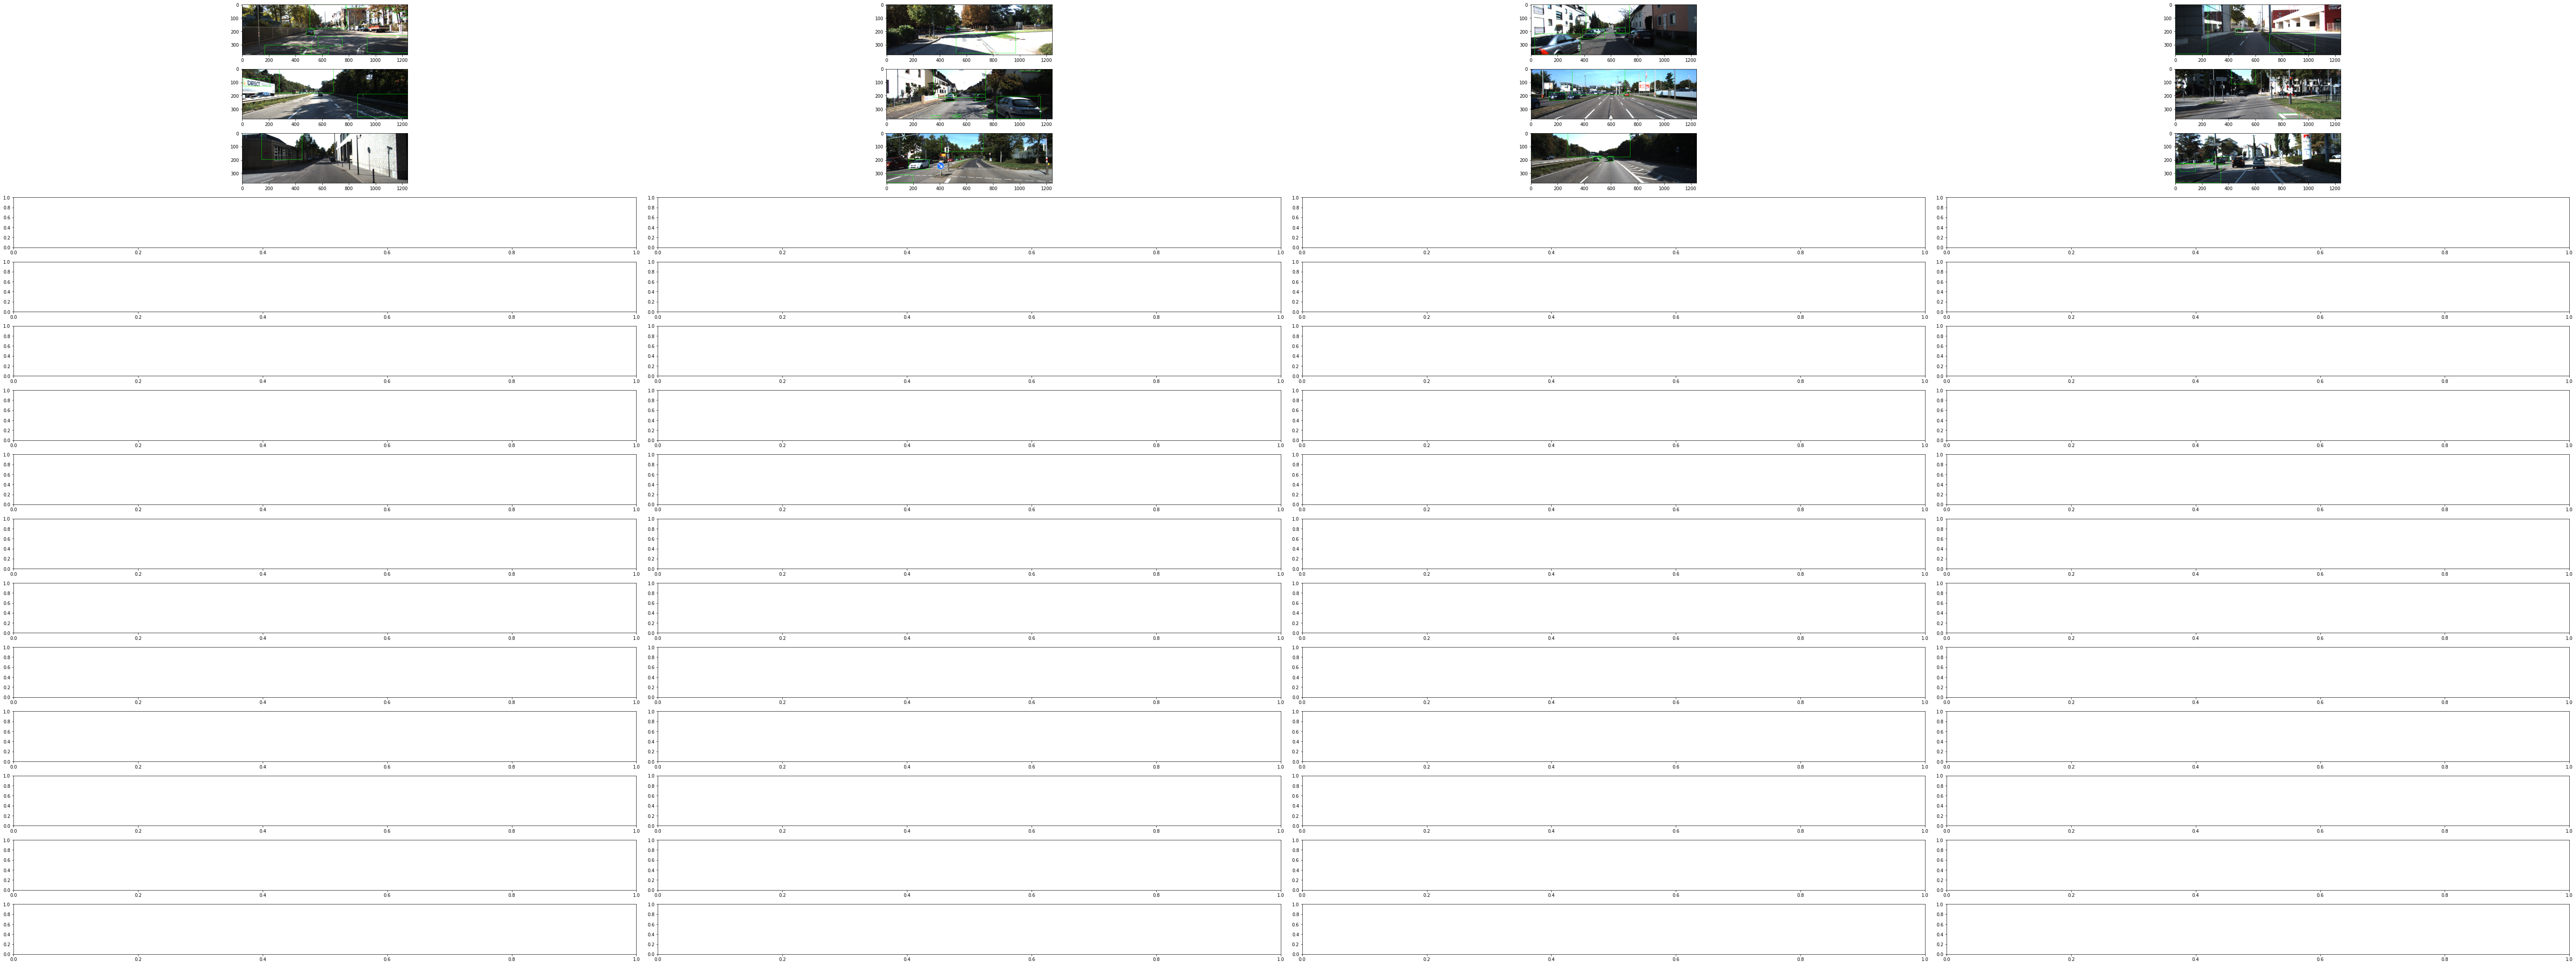

In [18]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'tlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
frompic = 58 # number of images to visualize.
topic = 70
visualize_images(OUTPUT_PATH, num_cols=COLS, imgfrom=frompic, imgto=topic)

## 10. Model Export <a class="anchor" id="head-10"></a>

In [ ]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/traffic_final_UA
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'],
                         "traffic_final_UA/resnet18_traffic_detector.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
!tlt detectnet_v2 export \
                  -m $USER_EXPERIMENT_DIR/traffic_dir_retrained_pruned_UA/weights/resnet18_traffic_detector_pruned.tlt \
                  -o $USER_EXPERIMENT_DIR/traffic_final_UA/resnet18_trafficcamnet_UA_Xue.etlt \
                  -k $KEY

In [ ]:
print('Exported model:')
print('------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/traffic_final_UA

### A. Int8 Optimization <a class="anchor" id="head-10-1"></a>
DetectNet_v2 model supports int8 inference mode in TensorRT. 
In order to use int8 mode, we must calibrate the model to run 8-bit inferences -

* Generate calibration tensorfile from the training data using detectnet_v2 calibration_tensorfile
* Use tlt-export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use atleast 10-20% of the training data to do so. The more data provided during calibration, the closer int8 inferences are to fp32 inferences.*

*Note: If the model was trained with QAT nodes available, please refrain from using the post training int8 optimization as mentioned below. Please export the model in int8 mode (using the arg `--data_type int8`) with just the path to the calibration cache file (using the argument `--cal_cache_file`)*

In [ ]:
!tlt detectnet_v2 calibration_tensorfile -e $SPECS_DIR/detectnet_v2_retrain_resnet18_xue.txt \
                                         -m 10 \
                                         -o $USER_EXPERIMENT_DIR/traffic_final_UA/calibration.tensor

In [ ]:
!rm -rf $LOCAL_EXPERIMENT_DIR/traffic_final_UA/resnet18__traffic_detector.etlt
!rm -rf $LOCAL_EXPERIMENT_DIR/traffic_final_UA/calibration.bin
!tlt detectnet_v2 export \
                  -m $USER_EXPERIMENT_DIR/traffic_dir_retrained_pruned_UA/weights/resnet18_traffic_detector_pruned.tlt \
                  -o $USER_EXPERIMENT_DIR/traffic_final_UA/resnet18_trafficcamnet.etlt \
                  -k $KEY  \
                  --cal_data_file $USER_EXPERIMENT_DIR/traffic_final_UA/calibration.tensor \
                  --data_type int8 \
                  --batches 10 \
                  --batch_size 4 \
                  --max_batch_size 4\
                  --engine_file $USER_EXPERIMENT_DIR/traffic_final_UA/resnet18_trafficcamnet.trt.int8 \
                  --cal_cache_file $USER_EXPERIMENT_DIR/traffic_final_UA/calibration.bin \
                  --verbose

### B. Generate TensorRT engine <a class="anchor" id="head-10-2"></a>
Verify engine generation using the `tlt-converter` utility included with the docker.

The `tlt-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tlt-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the converter for jetson from the dev zone link [here](https://developer.nvidia.com/tlt-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [ ]:
!tlt tlt-converter $USER_EXPERIMENT_DIR/traffic_final/resnet18_traffic_detector.etlt \
                   -k $KEY \
                    -c $USER_EXPERIMENT_DIR/traffic_final/calibration.bin \
                   -o output_cov/Sigmoid,output_bbox/BiasAdd \
                   -d 3,384,1248 \
                   -i nchw \
                   -m 64 \
                   -t int8 \
                   -e $USER_EXPERIMENT_DIR/traffic_final/resnet18_traffic_detector.trt \
                   -b 4

## 11. Verify Deployed Model <a class="anchor" id="head-11"></a>
Verify the exported model by visualizing inferences on TensorRT.
In addition to running inference on a `.tlt` model in [step 9](#head-9), the `inference` tool is also capable of consuming the converted `TensorRT engine` from [step 10.B](#head-10-2).

*If after int-8 calibration the accuracy of the int-8 inferences seem to degrade, it could be because the there wasn't enough data in the calibration tensorfile used to calibrate thee model or, the training data is not entirely representative of your test images, and the calibration maybe incorrect. Therefore, you may either regenerate the calibration tensorfile with more batches of the training data and recalibrate the model, or calibrate the model on a few images from the test set. This may be done using `--cal_image_dir` flag in the `export` tool. For more information, please follow the instructions in the USER GUIDE.

### A. Inference using TensorRT engine <a class="anchor" id="head-11-1"></a>

In [ ]:
!tlt detectnet_v2 inference -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt.txt \
                            -o $USER_EXPERIMENT_DIR/etlt_infer_testing \
                            -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                            -k $KEY

In [ ]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'etlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 11. QAT workflow <a class="anchor" id="head-12"></a>
This section delves into the newly enabled Quantization Aware Training feature with DetectNet_v2. The workflow defined below converts a pruned model from section [5](#head-5) to enable QAT and retrain this model to while accounting the noise introduced due to quantization in the forward pass. 

### A. Convert pruned model to QAT and retrain <a class="anchor" id="head-12-1"></a>
All detectnet models, unpruned and pruned models can be converted to QAT models by setting the `enable_qat` parameter in the `training_config` component of the spec file to `true`.

In [ ]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to convert the
# pretrained model to qat mode by setting the enable_qat
# parameter.
!cat $LOCAL_SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt

In [ ]:
!tlt detectnet_v2 train -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat \
                        -k $KEY \
                        -n resnet18_detector_pruned_qat \
                        --gpus $NUM_GPUS

In [ ]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights

### B. Evaluate QAT converted model <a class="anchor" id="head-12-2"></a>
This section evaluates a QAT enabled pruned retrained model. The mAP of this model should be comparable to that of the pruned retrained model without QAT. However, due to quantization, it is possible sometimes to see a drop in the mAP value for certain datasets.

In [ ]:
!tlt detectnet_v2 evaluate -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights/resnet18_detector_pruned_qat.tlt \
                           -k $KEY \
                           -f tlt

### C. Export QAT trained model to int8 <a class="anchor" id="head-12-3"></a>
Export a QAT trained model to TensorRT parsable model. This command generates an .etlt file from the trained model and the serializes corresponding int8 scales as a TRT readable calibration cache file.

In [ ]:
!rm -rf $LOCAL_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.etlt
!rm -rf $LOCAL_EXPERIMENT_DIR/experiment_dir_final/calibration_qat.bin
!tlt detectnet_v2 export \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights/resnet18_detector_pruned_qat.tlt \
                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.etlt \
                  -k $KEY  \
                  --data_type int8 \
                  --batch_size 64 \
                  --max_batch_size 64\
                  --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.trt.int8 \
                  --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration_qat.bin \
                  --verbose

### D. Evaluate a QAT trained model using the exported TensorRT engine <a class="anchor" id="head-12-4"></a>
This section evaluates a QAT enabled pruned retrained model using the TensorRT int8 engine that was exported in [Section C](#head-12-3). Please note that there maybe a slight difference (~0.1-0.5%) in the mAP from [Section B](#head-12-2), oweing to some differences in the implementation of quantization in TensorRT.

*Note: The TensorRT evaluator might be slightly slower than the TLT evaluator here, because the evaluation dataloader is pinned to the CPU to avoid any clashes between TensorRT and TLT instances in the GPU. Please note that this tool was not intended and has not been developed for profiling the model. It is just a means to qualitatively analyse the model.*

*Please use native TensorRT or DeepStream for the most optimized inferences.*

In [ ]:
!tlt detectnet_v2 evaluate -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.trt.int8 \
                           -f tensorrt

### E. Inference using QAT engine <a class="anchor" id="head-12-5"></a>
Run inference and visualize detections on test images, using the exported TensorRT engine from [Section C](#head-12-3).

In [ ]:
!tlt detectnet_v2 inference -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt_qat.txt \
                            -o $USER_EXPERIMENT_DIR/tlt_infer_testing_qat \
                            -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                            -k $KEY

In [ ]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'tlt_infer_testing_qat/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)